<a href="https://colab.research.google.com/github/PavanBorigi/FMML-22B21A42C2/blob/main/Project_Module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Project

```
Coordinator: Abhiroop Talasila
```

---



From 2020 to 2022, we have been severely affected by the COVID-19 pandemic. And if you would know a little about it, you would have heard about **SARS-CoV-2** (Severe Acute Respiratory Syndrome Coronavirus 2) which is the virus responsible for the COVID-19 disease.

A little biology might intrigue you further. This SARS-CoV-2 is a RNA virus and when this virus enters your body, it interacts with the ACE-2 receptor using its Spike protein. When this happens, it gets access to be able to multiply inside your body, ultimately resulting in you getting infected with the COVID-19 disease.

Before I explain you the details of the project and what you will be doing, let me first introduce you to what a virus genome is. Every living organism in this world has someting called a Nucleus which produces its characteristic genome sequence. Even your body has a genome and it will be very different from that of lets say a cat. Now, this SARS-CoV-2 virus also has its characteristic genome sequence and it is roughly of the length 29000 bases. A little more Class 9 biology lesson: Each genome is built up with just 4 characters called bases (A, T, G and C).

For this project, I will provide you with some SARS-CoV-2 genomes collected from infected people in India and you will use just the Visualization techniques you learnt in the module to analyze the genomes and infer the spread of the COVID-19 disease in the country.

685 genome sequences from India downloaded from GISAID (https://www.gisaid.org/) in early to mid 2020 have been provided to you in the _sequences.fasta_ file and some cleaned metadata regarding these sequences has been given in the _INDIA_685.csv_ file.


> Please download the required files from [here](https://drive.google.com/file/d/1dYlfg9j1oq0Wxi7epmHUP2NAgqemUCQc/view?usp=sharing) and upload when asked.

In [1]:
from google.colab import files

In [ ]:
# Upload Module2_ProjectFiles.zip file here by running this cell

uploaded = files.upload()
loc_ = list(uploaded.keys())[0]
!unzip -q {loc_}

In [ ]:
!pip3 -q install biopython

import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm.autonotebook import tqdm

In [ ]:
data = pd.read_csv("INDIA_685.csv")
data.tail()

In [ ]:
fasta_sequences = SeqIO.parse(open("sequences.fasta"),'fasta')

counter = 0
for fasta in fasta_sequences:
    counter +=1

print("Number of sequences is:", counter)

You might have heard in the news that the SARS-CoV-2 is mutating and might have heard the words Double Mutant, Delta Variant and so on. These are nothing but very slight differences in the genomes caused due to Mutations. Some of these mutations end up making the virus deadlier or more infectious.

Our goal here is to analyze these genomes and find the ones closer to one another (similar mutations in both) or distant (different profile of mutations). These mutations in turn help us to understand the spread of the Virus and the Demographics of it. Imagine a sequence from Italy has the same set of 10 random mutations as a sequence in India. We can then infer that the source of infection for both the people could be the same. This sort of analysis helps us analyze hotspots and predict if a large outbreak is about to happen.

We will try to look at these genome sequences and be able to cluster similar ones together and distant ones furhter away. In this project you will be using two methods to do this:

**1. k-mer based methods** <br>
**2. Mutation Profile based methods**

# kmer based methods

In bioinformatics, k-mers are substrings of length k contained within a biological sequence. A sequence of length L will have ```L-k+1 k-mers``` and ```4^k total possible k-mers```. Here we, will be using kmers of size 7. We will represent each genome in this kmer space. Basically a genome of size 30000 bases would have a total of 29994 7-mers.

**Now how do you use this information to cluster genome sequences?** <br>
We would be looking at the counts of different kmers in the genomes and the ones which have similar counts for different kmers should end up closer than the others.

For **k=7**, there are **16384** possible kmers. We will represent each genome sequence as a vector of size 16384 with each position scoring the frequency of the kmer corresponding to that position.

**But how do we find out the position in the array for a kmer?**<br>
We will be using a hash function to map each kmer to a position in the array (0 to 16383). Whenever that kmer will be observed in a sequence, the value at the corresponding position in the array would be increased by 1.

#### Hash function:

A: 0 <br>
G: 1<br>
T: 2<br>
C: 3<br>

Multiply the character value by ```4^(position of the character in the kmer)``` <br>
therefore, TAG would equal = (4^0 * 2) + (4^1 * 0) + (4^2 * 1) = 2 + 0 + 16 = 18

**Can you find out the hash value for CATCGAG?**

In [ ]:
def calc_score(examplesequence):

    position = 0
    score = 0
    value = 0
    flag = 0

    for base in examplesequence:

        if(base == "A" or base == "a"):
            value = 0
        elif(base == "G" or base == "g"):
            value = 1
        elif(base == "T" or base == "t"):
            value = 2
        elif(base == "C" or base == "c"):
            value = 3
        else:
            flag=1

        score += (4 ** position)* value
        position+=1

    return (flag,score)

calc_score("ATAGTAG")

In [ ]:
k=7
big_matrix = []
sequences_name = []

fasta_sequences = SeqIO.parse(open("sequences.fasta"),'fasta')

for fasta in tqdm(fasta_sequences):

    embedding = np.zeros(4**k, dtype=int)
    sequence = str(fasta.seq)
    sequence_name = fasta.id
    sequences_name.append(sequence_name)

    for j in range(len(sequence)-k+1):
        kmer = sequence[j:j+k]
        flag,score = calc_score(kmer)
        if(flag!=1):
            embedding[score]+=1

    embedding = embedding.tolist()
    big_matrix.append(embedding)

In [ ]:
print("Number of sequences:", len(sequences_name))
print("Number of features for each sequence:", len(big_matrix[0]))

So essentially we reduced a **29000 base sequence** into a **vector of size 16384**. Now we need to further reduce the dimensionality to 2 or 3 dimensions to be able to visualize it.

**But how dow we do that??**

We can use any of the methods taught to you in the Labs. But here I will explain how to do this using PCA. Then you will use the knowledge from Lab3 on t-SNE to do a similar analysis yourself.

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA() # create a PCA object
pca.fit(big_matrix) # do the math
pca_data = pca.transform(big_matrix) # get PCA coordinates for the matrix

In [ ]:
import matplotlib.pyplot as plt

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels_all = ['PC'+str(x) for x in range(1, len(per_var)+1)]
per_var=per_var[:10]
labels = [str(x) for x in range(1, len(per_var)+1)]

with plt.style.context('dark_background'):
    plt.figure(figsize = (15, 9))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels, color = "aqua")
    plt.plot(range(1,len(per_var)+1), np.cumsum(per_var), color = "red")
    plt.scatter(range(1,len(per_var)+1), np.cumsum(per_var), color = "yellow")

As you can see, the first principal component alone explains more than 50% of the variance in the dataset. To put this into context, more than **50% variance in 685 genomes of size 29000 bases could be explained with just one dimension**. This shows the amount of structure present in the dataset.

We will be now visualizing the first 2 principal components and plot the genomes according to the State they belonged to.

In [ ]:
final_df = pd.DataFrame(columns=["StrainID", "PC1", "PC2", "PC3", "State"])
pca_df = pd.DataFrame(pca_data, index=[*sequences_name], columns = labels_all)

for sample in pca_df.index:

    dicti = dict()

    dicti["StrainID"] = sample
    dicti["PC1"] = pca_df.PC1.loc[sample]
    dicti["PC2"] = pca_df.PC2.loc[sample]
    dicti["PC3"] = pca_df.PC3.loc[sample]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]

    final_df = pd.concat([final_df, pd.DataFrame([dicti])], ignore_index=True)

final_df.head()

In [ ]:
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
for_x = final_df.PC1.tolist()
for_y = final_df.PC2.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, title="Principal Component Axis",
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"
                })

fig.show(renderer = "colab")

Even though the plot looks densely clustered, there are still a lot of obvious observations that you should be able to make.

### The first one, is that for some reason the Blue dots (Odisha) are scattered away from the big main cluster.

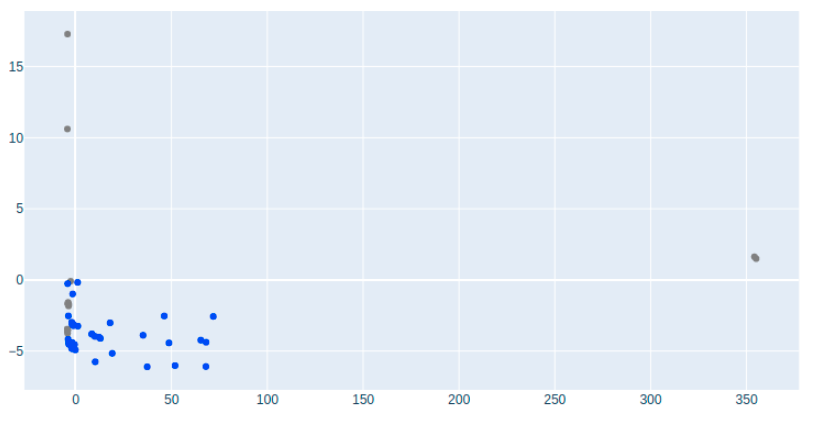

### Also, we can observe a secondary cluster away from the primary cluster. On inspecting, we can see that the sequences forming this cluster are primarily from Telangana (red), Delhi (magenta), and Tamil Nadu (green).

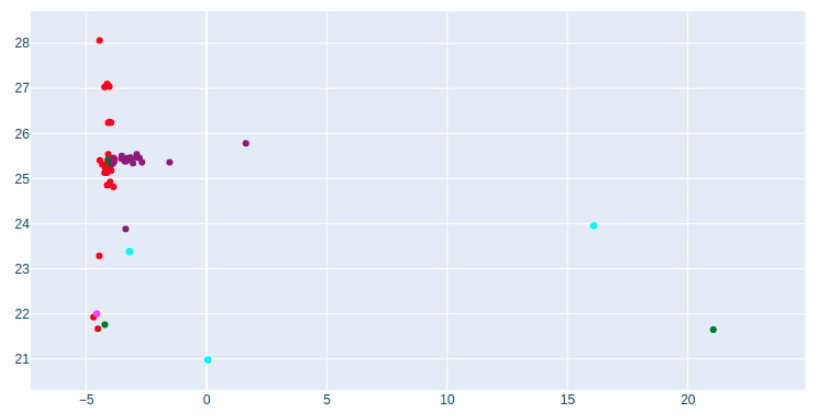

### The third less obvious observation is that within the main cluster, there is a dense cluster of sequences from Gujarat.

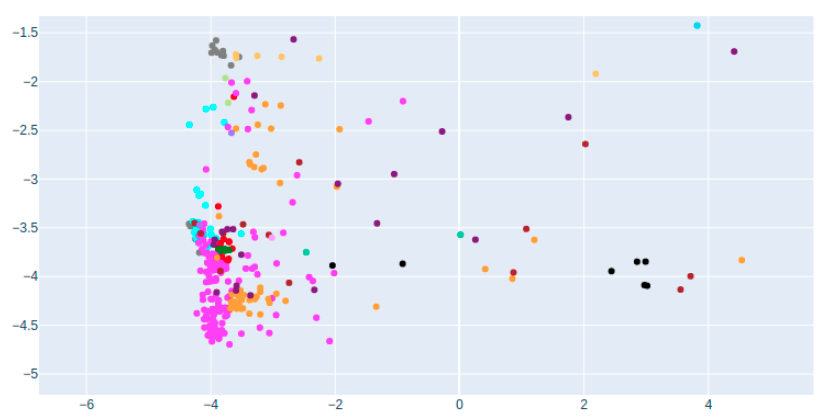

## t-SNE

In [ ]:
from sklearn.manifold import TSNE

# Use these parameters
random_state = 0
n_components = 2
perplexity = 30
n_iter = 10000

####### Enter code below #######
model = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, n_iter=n_iter)
tsne_data = model.fit_transform(np.array(big_matrix))

#####################

In [ ]:
final_df = pd.DataFrame(columns=["StrainID", "X", "Y", "State"])
pca_df = pd.DataFrame(pca_data, index=[*sequences_name], columns = labels_all)

i = 0
for sample in pca_df.index:

    dicti = dict()

    dicti["StrainID"] = sample
    dicti["X"] = tsne_data[i][0]
    dicti["Y"] = tsne_data[i][1]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]

    final_df = pd.concat([final_df, pd.DataFrame([dicti])], ignore_index=True)
    i+=1

final_df.tail()

In [ ]:
for_x = final_df.X.tolist()
for_y = final_df.Y.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, title="t-SNE", height=600, width=1000,
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"})

fig.show(renderer = 'colab')

Does making the 3 observations become easier in this plot? Can you make any other new observations from this plot?

Make sure you tweak the parameters to find out if a certain different setting is allowing you to get a more interpretable plot.

# Mutation Profile based methods

If you would have noticed, there is a column called Nuc_muts (Nucleotide mutations) in the INDIA_685.csv file. These are the specific mutations for each sequence which I have precomputed for you using the first SARS-CoV-2 sequence from Wuhan, China (https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.2?report=fasta) as the reference.

A mutation C453T in a sequence means that the original reference sequence from Wuhan had a C at position 453 whereas the sequence has a T at that position.

Now instead of using kmers for sequences, this time we will use the **presence/absence of all mutations** found in our dataset to represent the genomes.

In [ ]:
## First we need to get the list of all unique mutations observed in our dataset.

mutations = []
for i in range(len(data)):

    sample_muts = data["Nuc_muts"][i][1:][:-1].split(",")

    for j in sample_muts:
        mut = j.strip()[1:][:-1]
        if(len(mut)>=2):
            if(mut not in mutations):
                mutations.append(mut)

print(len(mutations))

So there are 1279 unique mutations in our sequences. We can now represent each genome as a ```vector of size 1279 where each position indicates the presence (1) or absence (0) of a specific mutation```.

In [ ]:
samplelist = data["StrainID"].tolist()
df = pd.DataFrame(columns = [*samplelist])
df = df.replace(np.nan,0)

for mutation in mutations:

    dicti = dict(zip(samplelist, np.zeros(len(samplelist), dtype=int)))

    for i in range(len(data)):
        flag=0
        strainid = data["StrainID"][i]
        sample_muts = data["Nuc_muts"][i][1:][:-1].split(",")

        for j in sample_muts:
            mut = j.strip()[1:][:-1]
            if(len(mut)>=2):
                if(mut == mutation):
                    flag = 1
                    break

        dicti[strainid]=flag

    df = pd.concat([df, pd.DataFrame([dicti])], ignore_index=True)

df = df.T

df.tail()

## PCA

Performing PCA on this dataframe, we want to reduce the dimensionality of our genome sequences from 1279 to 2.

In [ ]:
pca = PCA()
pca.fit(df)
pca_data = pca.transform(df)

In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels_all = ['PC'+str(x) for x in range(1, len(per_var)+1)]
per_var=per_var[:10]
labels = [str(x) for x in range(1, len(per_var)+1)]

with plt.style.context('dark_background'):
    plt.figure(figsize = (15, 9))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels, color = "aqua")
    plt.plot(range(1,len(per_var)+1), np.cumsum(per_var), color = "red")
    plt.scatter(range(1,len(per_var)+1), np.cumsum(per_var), color = "yellow")

The first principal component should be able to capture close to 30% of the variance in the dataset.

In [ ]:
final_df = pd.DataFrame(columns=["StrainID", "PC1", "PC2", "State"])
pca_df = pd.DataFrame(pca_data, index=[*samplelist], columns = labels_all)

for sample in pca_df.index:

    dicti = dict()

    dicti["StrainID"] = sample
    dicti["PC1"] = pca_df.PC1.loc[sample]
    dicti["PC2"] = pca_df.PC2.loc[sample]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]

    final_df = pd.concat([final_df, pd.DataFrame([dicti])], ignore_index=True)

final_df.tail()

In [ ]:
for_x = final_df.PC1.tolist()
for_y = final_df.PC2.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, height=600, width=1200,
                 title="Principal Component Axis",
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"})
fig.show(renderer = 'colab')

This makes the above observations so much easier. Can you list them with respect to this plot?

# t-SNE

Now this time you will be expected to write more than just 3 lines of the code to get the t-SNE plot for this data. Make sure you play with the **perplexity** values enough to appreciate the algorithm. I hope you are able to retrieve the 3 observations and make some new ones from the plot.

---

You are encouraged to also implement **ISOMAP (from Lab-4)** and try to get more insights from the plots.

# Conclusion

You might be wondering how these 3 observations help in understanding the demographic spread of the virus in the country.

### This is not a Bioinformatics course, so you may choose to ignore the details mentioned below
But the idea was to motivate you to understand the importance of visualization techniques even with no domain knowlege.

---
---

On performing genetic analysis on the sequences to understand why exactly these observations could have been happening I found the following:

#### Observation 1:
Samples from Odisha are different than the rest of the country, hence they were scattered away from the clusters in the plots.

#### Reason:
Genomic sequences of isolates from Odisha were shorter in length with missing bases (deletions); 1 - 29 bases in 5' UTR (38 isolates), 23842 - 24400 bases in S gene, 26306-26524 bases in E gene, 27527 – 28033 bases in ORF7b and ORF8 (8 samples), 28462 - 28680 bases in the N gene (10 samples), 29000 – 29685 in ORF10 gene (15 samples), and 29686 - 29903 bases in 3' UTR (39 isolates). These deletions were unique to the state and werent observed in samples from the rest of the country.

#### Observation 2:
A secondary cluster away from the primary cluster with sequences from Telangana, Delhi, and Tamil Nadu.

#### Reason:
About one-third of the Indian isolates (219/685) are part of a subclade I/A3i defined by the co-occurring mutations C6312A, C13730T, C23929T, and C28311T. The subclade's predominance is observed in Telangana (69/97, 71%), Delhi (52/76, 68%), and Tamil Nadu (16/34). Analysis of this subclade is important both scientifically and epidemiologically as the mutations defining it are found in 32% of the Indian samples sequenced, while outside India its distribution is very low (3.5%). This clearly hints at early community transmission due to some super spreader event during March-April, as it is highly unlikely that around one-third of the samples sharing the same set of mutations could have arisen by multiple independent entries with international travel history, especially when its presence globally is negligibly small.

#### Observation 3:
A dense cluster of sequences from Gujarat.

#### Reason:
Isolates from Gujarat are a part of a subclade, I/GJ-20A defined by a shared set of mutations C18877T, G25563T (ORF3a: Q57H), and C26735T. This set of mutations are not well represented in the rest of the country. Mutations present in Gujarat have also been found in samples from Europe and that could have been the possible route of transmission into India. Also, Gujarat has the highest COVID-19 death rate (5.12%) in the country (Avg: 2.67%), and this death rate in Gujarat is comparable to that in Europe. This high fatality could be due to these characteristic mutations increasing the deleteriousness of the virus.

---

**So I hope you appreciate the valuable insights visualization techniques provide us with.**

Best of luck for the next Module!
---